In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Objectives:

We want to look at bandits where the rewards are only 1 or 0 (Bernouilli).

There is one method (Bayesian) that we did not see during the course.
Some explanations there:
https://towardsdatascience.com/thompson-sampling-fc28817eacb8


1) COMPLETE the code where it says "COMPLETE".

2) Do simulations for a bandit with 2 arms P = [0.4, 0.8] for each of the mentionned decision rule and plot the corresponding  mean reward; the mean cumulative reward and the percentage of times the best arm was elected as time goes by. Interpret. 

3) Do simulations with a bandit with 10 arms (P = [0.2, 0.2, 0.4, 0.2, 0.2, 0.2, 0.2, 0.8, 0.2, 0.2]). Plot the corresponding  mean reward; the mean cumulative reward and the percentage of times the best arm was elected as time goes by. Interpret.  
Play with the c parameter in UCB.

4) Study the dependence of the hyperparameter epsilon in the decision rule epsilon-greedy.

5) What are your conclusions in terms of methods? Give some intution.



In [ ]:
class BernoulliBanditEnv(object): 
    # Class that defines the environment with reward 0 and 1 with probability p.

    def __init__(self, num_arms=10, p=None):
        self.num_arms = num_arms
        self.actions = np.arange(num_arms)     # define set of actions

        if len(p)==1:
            self.p = np.random.beta(0.5, 0.5, size=num_arms)
        elif len(p) == num_arms:
            self.p = p
        else:
            raise Exception('Number of probabilities ({}) does not correspond to number of arms ({}).'.format(len(q), num_arms))
        self.best_action = np.argmax(self.p)   # Best action given env

    def reward(self, action):
        return np.random.binomial(1, p=self.p[action])


In [ ]:
from scipy.stats import beta
class Agent(object):
    # Class which defines the agent. Each agent has a decision rule and a learning rule.
    
    def __init__(self, learning_rule, decision_rule, param=None):
        self.decision_rule = decision_rule
        self.learning_rule = learning_rule

        if decision_rule == "epsilon-greedy":
            self.epsilon = param["epsilon"]
        
        if decision_rule == "UCB":
            self.UCB_param = param["UCB_param"]
    
    def environment(self, env, init_q):
        # initialize environment
        self.env = env                                  
        self.k = env.num_arms                           
        self.actions = np.arange(self.k)                
        self.act_count = np.ones(self.k) * 1e-5           
        self.iteration = 0     
        if self.learning_rule == "BayesianBetaPrior":
            self.alpha = np.random.uniform(size=self.k)
            self.beta = np.random.uniform(size=self.k)
        if len(init_q) == self.k:
            self.q_estimate = init_q
        else:
            raise Exception('Number of initial values ({}) does not correspond to number of arms ({}).'.format(len(init_q), self.k))

    def learn(self, a, r):
        # given action and reward, update value function.
        if self.learning_rule == "averaging":
            self.q_estimate[a] += 1/self.act_count[a] * (r - self.q_estimate[a])
            
        if self.learning_rule == "BayesianBetaPrior":
            self.alpha[a] += r
            self.beta[a] += 1 - r 
            
    def act(self):
        # action.
        self.iteration += 1

        ######Greedy policy(special case of epsilon greedy where epsilon=0)#####
        if self.decision_rule == "greedy":
            action = np.argmax(self.q_estimate)
            check = np.where(self.q_estimate == self.q_estimate[action])[0]
            if len(check) == 1:
                selected_action = action
            else:
                selected_action = np.random.choice(check)
        ########################################################################

        ######epsilon-greedy policy#############################################
        if self.decision_rule == "epsilon-greedy":
            if np.random.random() < self.epsilon:
                selected_action = np.random.choice(len(self.q_estimate))
            else:
                action = np.argmax(self.q_estimate)
                check = np.where(self.q_estimate == self.q_estimate[action])[0]
                if len(check) == 1:
                    selected_action = action
                else:
                    selected_action = np.random.choice(check)
        ########################################################################
        
        ##########Upper confidence bound policy#################################
        if self.decision_rule == "UCB":
            exploration = np.log(self.iteration+1) /self.act_count
            exploration[np.isnan(exploration)] = 0
            exploration = np.power(exploration, 1/self.UCB_param)

            q = self.q_estimate + exploration
            action = np.argmax(q)
            check = np.where(q == q[action])[0]
            if len(check) == 1:
                selected_action = action
            else:
                selected_action = np.random.choice(check)
        ########################################################################

        ############Thompson sampling policy####################################
        if self.decision_rule == "Thompson":
            beta_params = zip(self.alpha, self.beta)
        
          # Perform random draw for all arms based on their parameters alpha and beta
            check = [beta.rvs(i[0], i[1], size = 1) for i in beta_params]

            selected_action = check.index(max(check))
        ########################################################################
            
        
        self.act_count[selected_action] += 1
        return selected_action

In [ ]:
def simulateBandits(agents, narms, initp=None, initq=None, repetitions=1000, N=100):
    # function that simulates the agents behaviour
    # agents is a list of agents.
    
    rewards = np.zeros((len(agents), repetitions, N))
    cum_rewards = np.zeros((len(agents), repetitions, N))
    bestarm = np.zeros((len(agents), repetitions, N))
    for i, agent in enumerate(agents):
        for j in np.arange(repetitions):
            environment = BernoulliBanditEnv(num_arms=narms, p=initp)
            agent.environment(environment, initq if not(initq == None) else np.zeros(narms))
            r_c=0
            for n in np.arange(N):
                a = agent.act()
                r = environment.reward(a)
                agent.learn(a, r)
                rewards[i, j, n] = r
                bestarm[i, j, n] = 1 if a == environment.best_action else 0
                r_c +=r
                cum_rewards[i, j, n] = r_c
    
    return np.squeeze(np.mean(rewards, axis=1)),  np.squeeze(np.mean(bestarm, axis=1))

In [ ]:
from matplotlib import gridspec
def plot_results(agents, actions, rewards):
    episodes = 100
    fig = plt.figure(figsize=(20,15))
    fig.set_figwidth(20)
    l = len(agents)
    spec = gridspec.GridSpec(ncols=3, nrows=l)
    for i in range(l):
        ax1 = fig.add_subplot(spec[i,0])
        ax2 = fig.add_subplot(spec[i,1])
        ax3 = fig.add_subplot(spec[i,2])
        cum_re = np.cumsum(rewards[i])
        ax1.plot(rewards[i])
        ax1.set_title("Mean reward")
        ax2.plot(cum_re)
        ax2.set_title("Mean cumul reward")
        ax3.plot(actions[i])
        ax3.set_title("% Best arm used")
    #plt.show()


**Simulations for a bandit with 2 arms P = [0.4, 0.8]**

In [ ]:
# We create an agent for each decision rule
a_greedy = Agent(learning_rule="averaging", decision_rule="greedy")
a_eps_greedy = Agent(learning_rule="averaging", decision_rule="epsilon-greedy", param={"epsilon":0.4})
a_ucb = Agent(learning_rule="averaging", decision_rule="UCB", param={"UCB_param":0.2})
a_thompson = Agent(learning_rule="BayesianBetaPrior", decision_rule="Thompson")

# We create a list containing all the agents defined above
a=[a_greedy, a_eps_greedy, a_ucb, a_thompson]

In [ ]:
# For each agent, we simulate the bandits problems 1000 times for 100 iterations.
re, ac = simulateBandits(agents=a, narms=2, initp=[0.4, 0.8])

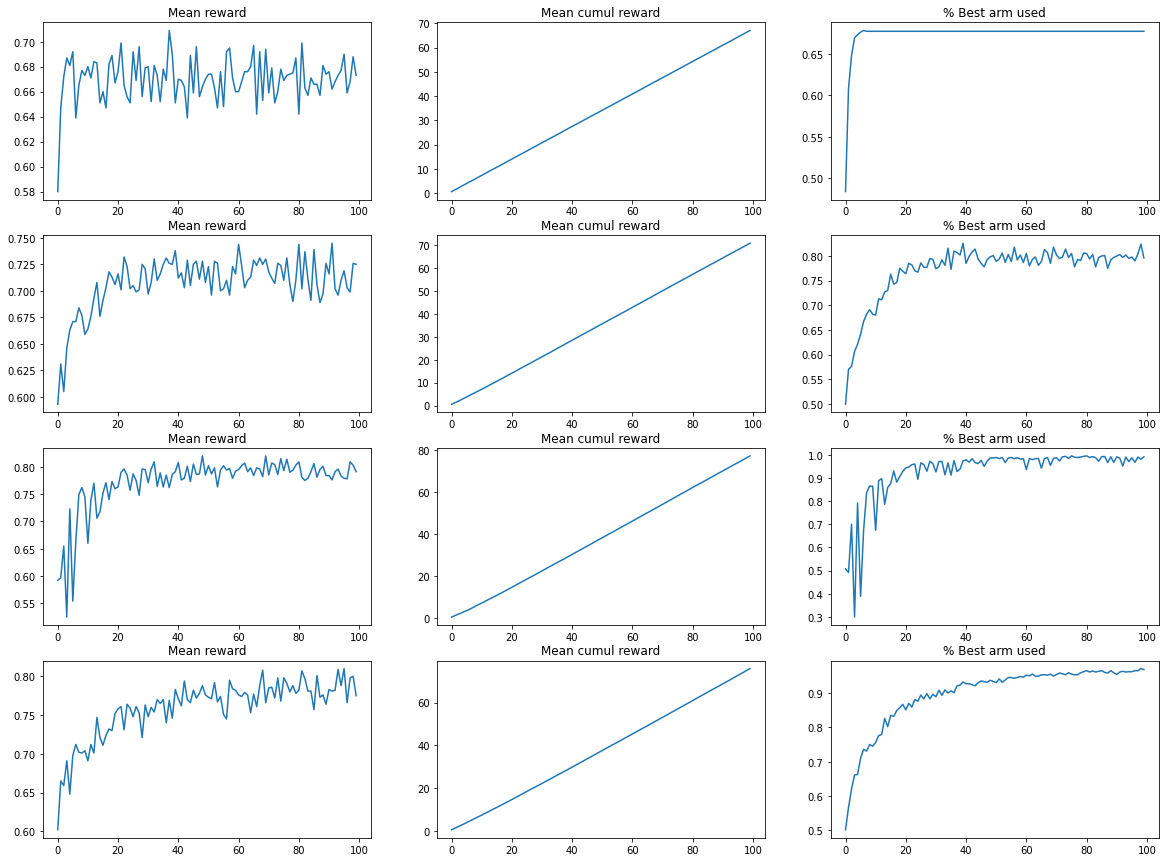

In [ ]:
# We plot the mean reward, the mean cumulative reward and % of times the best arm was used throug time
plot_results(a, ac, re)

-Greedy algorithm converges faster than the three other algorithms, but it underperforms compared to them. 

-UCB converges faster than epsilon-greedy and Thompson sampling and outperforms them in the long term. 

-Thompson decision rule performs better than epsilon-greedy. However, it took longer to converge.

**Simulations for a bandit with 10 arms P = [0.2, 0.2, 0.4, 0.2, 0.2, 0.2, 0.2, 0.8, 0.2, 0.2]**

In [ ]:
# We create a list in which we will store the agents that we will define below
a2 = []

# We create an agent for each decision rule
a2.append(Agent(learning_rule="averaging", decision_rule="greedy"))
a2.append(Agent(learning_rule="averaging", decision_rule="epsilon-greedy", param={"epsilon":0.4}))

### We study the impact of the hyperparameter c by changing its value with :[0.002, 0.2, 2, 20]#####
a2.append(Agent(learning_rule="averaging", decision_rule="UCB", param={"UCB_param":0.02}))
a2.append(Agent(learning_rule="averaging", decision_rule="UCB", param={"UCB_param":0.2}))
a2.append(Agent(learning_rule="averaging", decision_rule="UCB", param={"UCB_param":2}))
a2.append(Agent(learning_rule="averaging", decision_rule="UCB", param={"UCB_param":20}))
####################################################################################################

a2.append(Agent(learning_rule="BayesianBetaPrior", decision_rule="Thompson"))

In [ ]:
re2, ac2 = simulateBandits(agents=a2, narms=10, initp= [0.2, 0.2, 0.4, 0.2, 0.2, 0.2, 0.2, 0.8, 0.2, 0.2])

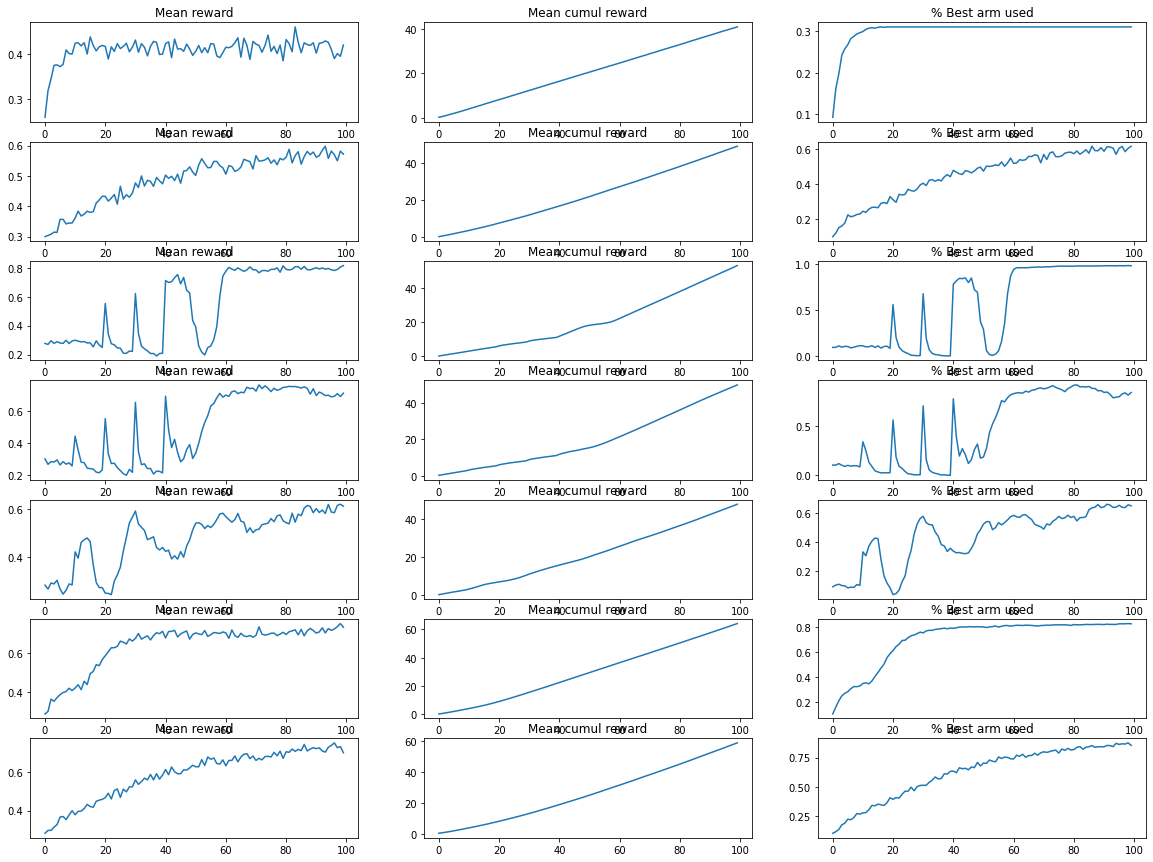

In [ ]:
plot_results(a2, ac2, re2)

-Greedy algorithm converges faster than the three other algorithms, but as observed before, underperforms compared to them. 

-The bigger the value c, the faster UCB converges and the more stable it is. However, in the long run, the best results across all decision rules were achieved with the smallest value: c $=0.002$

-Thompson decision rule outperforms epsilon-greedy, while both are stable and converge at a similar rate in this particular setting.

**The dependence of the hyperparameter epsilon in the decision rule epsilon-greedy**

In [ ]:
a3=[]
a3.append(Agent(learning_rule="averaging", decision_rule="epsilon-greedy", param={"epsilon":0.02}))
a3.append(Agent(learning_rule="averaging", decision_rule="epsilon-greedy", param={"epsilon":0.2}))
a3.append(Agent(learning_rule="averaging", decision_rule="epsilon-greedy", param={"epsilon":0.4}))
a3.append(Agent(learning_rule="averaging", decision_rule="epsilon-greedy", param={"epsilon":0.6}))
a3.append(Agent(learning_rule="averaging", decision_rule="epsilon-greedy", param={"epsilon":0.8}))
a3.append(Agent(learning_rule="averaging", decision_rule="epsilon-greedy", param={"epsilon":1}))

In [ ]:
# We store the results for the 1st experiment with 2 arms
re3_1, ac3_1 = simulateBandits(agents=a3, narms=2, initp=[0.4, 0.8])
# We store the results for the 2nd experiment with 10 arms
re3_2, ac3_2 = simulateBandits(agents=a3, narms=10, initp= [0.2, 0.2, 0.4, 0.2, 0.2, 0.2, 0.2, 0.8, 0.2, 0.2])

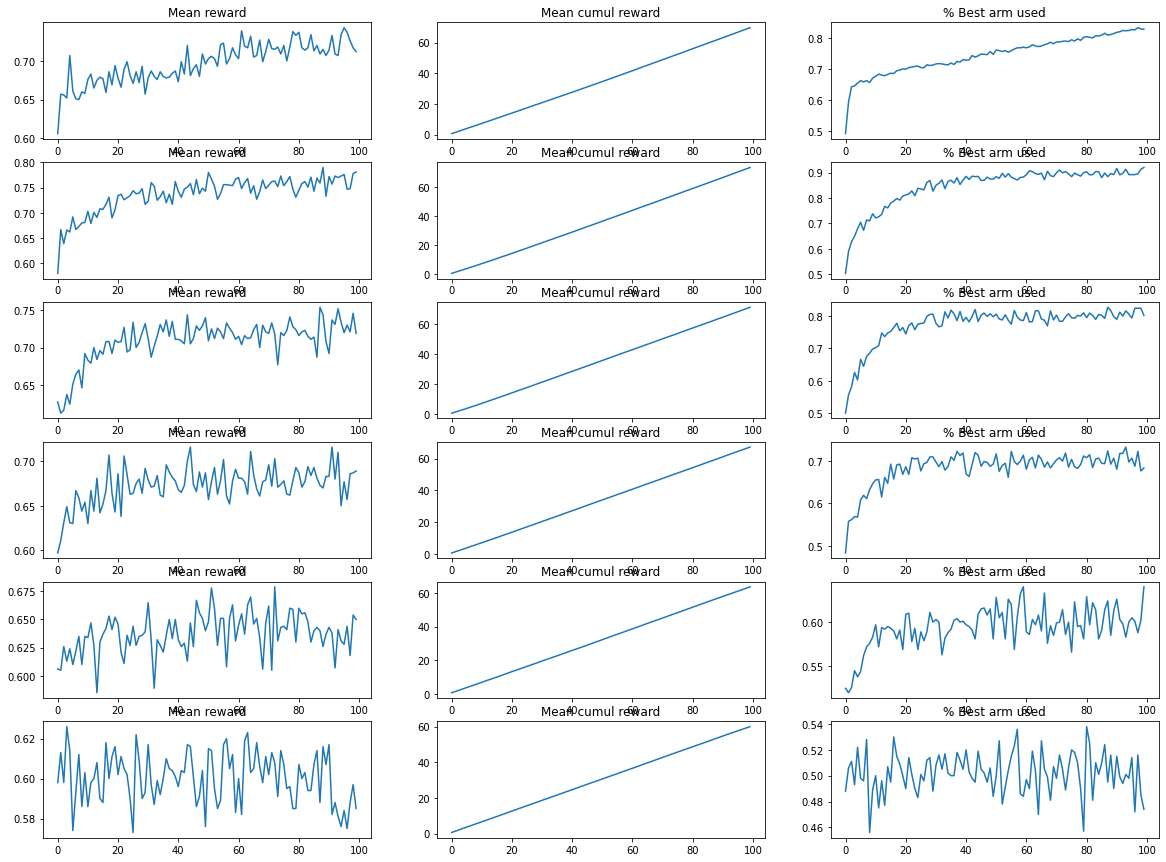

In [ ]:
#Plot the results of the 1st experiment
plot_results(a3, ac3_1, re3_1)

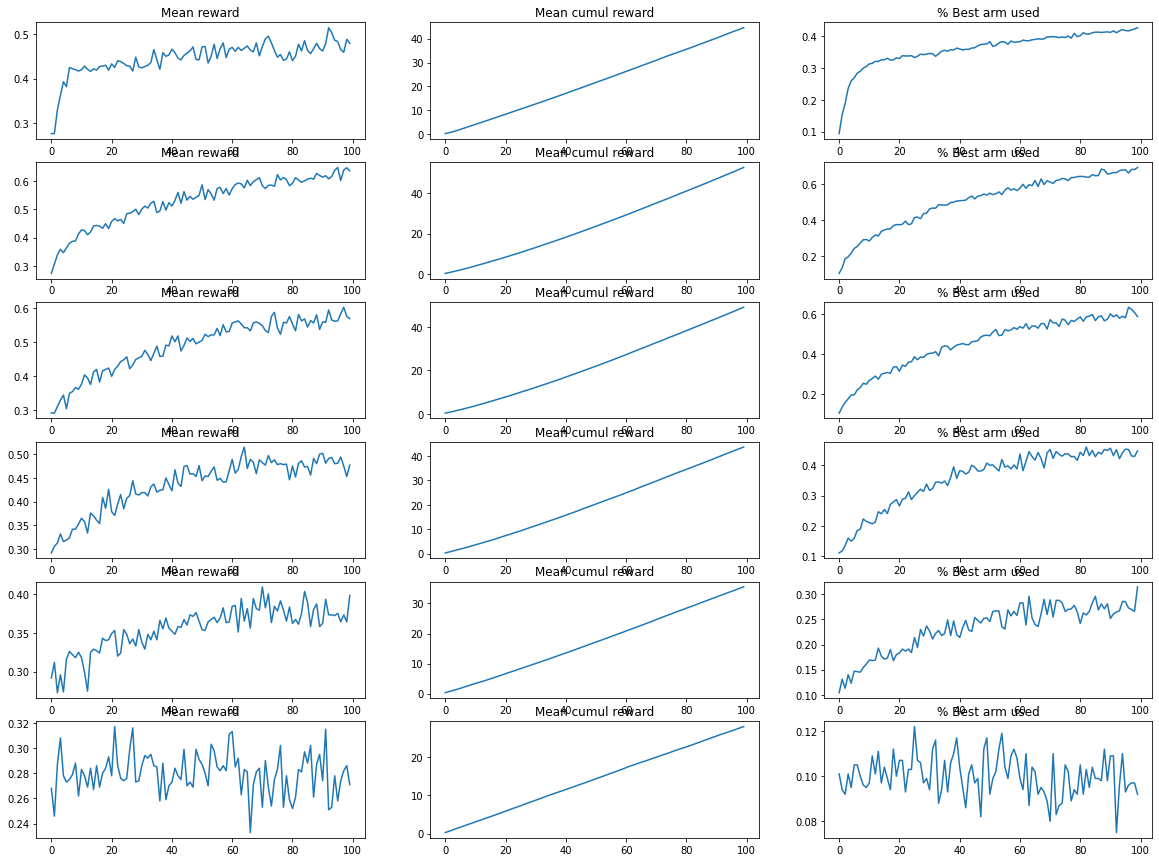

In [ ]:
#Plot the results of the 2nd experiment
plot_results(a3, ac3_2, re3_2)

We see that the performance is better with epsilon values between $0.1$ and $0.5$. 

The algorithm is a lot more stable, with smaller $\epsilon$ values. 

The convergence rate is much faster for small $\epsilon$ values while diverging completely for values close to $1$.